In [3]:
import json
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import numpy as np

## Process data

- Hexjson file for UK local Authorities from [ODI]() - format explanation [here](https://open-innovations.org/projects/hexmaps/hexjson.html)
- Cycling rates from [Active Lives Survey]()

### Hexagons

In [4]:
# open json file
with open('uk-local-authority-districts-2021.json') as file:
  hex_json = json.load(file)

# convert to dataframe
df = {"ONS Code": [], "name": [], "q":[], "r":[], "region":[]}
for code in hex_json["hexes"]:
    df["ONS Code"].append(code)
for items in hex_json["hexes"].values():
    df["name"].append(items["n"])
    df["q"].append(items["q"])
    df["r"].append(items["r"])
    df["region"].append(items["region"])
df = pd.DataFrame.from_dict(df)

# shift columns for odd row numbers for later viz
df["q_new"] = None
for i in range(len(df)):
    if df.loc[i, "r"] % 2:
        df.loc[i,"q_new"] = df.loc[i,"q"]
    else:
        df.loc[i,"q_new"] = df.loc[i,"q"] - 0.5

df

,ONS Code,name,q,r,region,q_new
0,E06000001,Hartlepool,8,19,E12000001,8
1,E06000002,Middlesbrough,9,18,E12000001,8.5
2,E06000003,Redcar and Cleveland,9,19,E12000001,9
3,E06000004,Stockton-on-Tees,8,18,E12000001,7.5
4,E06000010,"Kingston upon Hull, City of",10,15,E12000003,10
...,...,...,...,...,...,...
369,W06000019,Blaenau Gwent,0,9,W92000004,0
370,W06000024,Merthyr Tydfil,-2,8,W92000004,-2.5
371,W06000021,Monmouthshire,-1,8,W92000004,-1.5
372,W06000022,Newport,-1,5,W92000004,-1


### Data to display

In [100]:
# load cycling data
any = pd.read_excel("cw0302-proportion-of-adults-that-cycle-by-frequency-purpose-and-local-authority.xlsx", sheet_name="CW0302_Any_Purpose", skiprows=4)
leisure = pd.read_excel("cw0302-proportion-of-adults-that-cycle-by-frequency-purpose-and-local-authority.xlsx", sheet_name="CW0302_Leisure", skiprows=4)
travel = pd.read_excel("cw0302-proportion-of-adults-that-cycle-by-frequency-purpose-and-local-authority.xlsx", sheet_name="CW0302_Travel", skiprows=4)
data = pd.concat([any, leisure, travel])

# replace missing data
years = ['2016', '2017', '2018','2019', '2020', '2021', '2022']
for year in years:
    data[year] = data[year].replace("[u]", np.nan).replace("[note 6]", np.nan)

In [7]:
# load car ownership
cars = pd.read_excel("TS045-2021-3.xlsx")
cars = cars.pivot(index=['Lower Tier Local Authorities Code', 'Lower Tier Local Authorities'],
                 columns='Car or van availability (5 categories) Code', values='Observation').reset_index()
cars["total_car_owners"] = cars[[ 1,2,3]].sum(axis=1)
cars["prop_car_owners"] = cars[[ 1,2,3]].sum(axis=1)/cars[[ 0, 1,2,3]].sum(axis=1)*100
cars = cars.rename(columns={'Lower Tier Local Authorities Code':"ONS Code", 'Lower Tier Local Authorities': "LA Name"})
cars = cars[['ONS Code', 'LA Name',  0, 'total_car_owners', 'prop_car_owners']]

In [50]:
# load method of travel to work
data = pd.read_csv("TS061-2021-4.csv")
pivot = data.pivot(index=['Lower tier local authorities Code'],
               columns='Method used to travel to workplace (12 categories) Code', values='Observation').reset_index()
pivot["total_in_work"] = pivot[[1,2,3,4,5,6,7,8,9,10,11]].sum(axis=1)
pivot["prop_wfh"] =  pivot[1]/pivot["total_in_work"] *100
pivot["prop_foot"] =  pivot[10]/pivot["total_in_work"] *100
pivot["prop_bus"] =  pivot[10]/pivot["total_in_work"] *100
pivot = pivot.rename(columns={"Lower tier local authorities Code":"ONS Code"})

In [64]:
# load distance travelled to work
data = pd.read_csv("TS058-2021-3.csv")
pivot = data.pivot(index=['Lower Tier Local Authorities Code'],
               columns='Distance travelled to work (11 categories) Code', values='Observation').reset_index()
pivot["total_travel"] = pivot[[1,2,3,4,5,6,7,8]].sum(axis=1)
pivot["prop_20up"] =   pivot[[4,5,6,7,8]].sum(axis=1) / pivot["total_travel"] *100
pivot = pivot.rename(columns={"Lower Tier Local Authorities Code":"ONS Code"})

In [59]:
data

,Lower Tier Local Authorities Code,Lower Tier Local Authorities,Distance travelled to work (11 categories) Code,Distance travelled to work (11 categories),Observation
0,E06000001,Hartlepool,-8,Does not apply,54589
1,E06000001,Hartlepool,1,Less than 2km,5891
2,E06000001,Hartlepool,2,2km to less than 5km,7286
3,E06000001,Hartlepool,3,5km to less than 10km,3159
4,E06000001,Hartlepool,4,10km to less than 20km,5623
...,...,...,...,...,...
3636,W06000024,Merthyr Tydfil,6,30km to less than 40km,999
3637,W06000024,Merthyr Tydfil,7,40km to less than 60km,241
3638,W06000024,Merthyr Tydfil,8,60km and over,348
3639,W06000024,Merthyr Tydfil,9,Works mainly from home,4666


In [65]:
# merge
#data_filtered = data[(data["Frequency"]=="At least once per month") & (data["Purpose"]=="Any")]
df_plot = pd.merge(df, pivot, on="ONS Code", how="inner")

## Visualise

In [105]:
import matplotlib

norm = matplotlib.colors.Normalize(vmin=0, vmax=round(df_plot["2022"].max(),0))
cmap = matplotlib.colormaps["viridis"]

color = []
for i in range(len(df_plot)):
    color.append(cmap(norm(df_plot.loc[i,"2022"])))
df_plot["color"] = color

In [68]:
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
cmap = matplotlib.colormaps["Blues"]

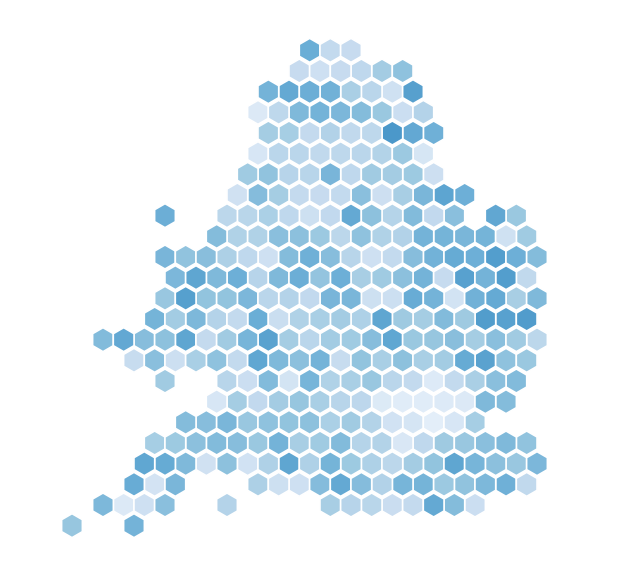

In [71]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

# Add some coloured hexagons
for x, y, v, l in zip(df_plot["q_new"], df_plot["r"], df_plot["prop_20up"], df_plot["name"]):
    hex = RegularPolygon((x, y), numVertices=6, radius=0.58, 
                         orientation=np.radians(0), 
                         facecolor=cmap(norm(v)), alpha=1, linewidth=1.2, edgecolor='white')
    ax.add_patch(hex)
    if v>90:
        ax.text(x, y+0.2, l, ha='center', va='center', size=10)
    

ax.set_xlim(-10,20)
ax.set_ylim(-5,22)
ax.axis('off')

plt.show()

## Tutorial

Found this [great answer](https://stackoverflow.com/questions/46525981/how-to-plot-x-y-z-coordinates-in-the-shape-of-a-hexagonal-grid) on StackOverFlow.

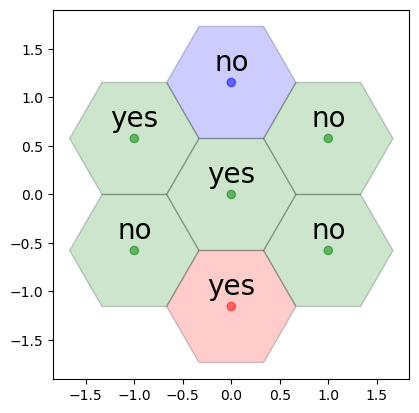

In [45]:
coord = [[0,0,0],[0,1,-1],[-1,1,0],[-1,0,1],[0,-1,1],[1,-1,0],[1,0,-1]]
colors = [["Green"],["Blue"],["Green"],["Green"],["Red"],["Green"],["Green"]]
labels = [['yes'],['no'],['yes'],['no'],['yes'],['no'],['no']]

# Horizontal cartesian coords
hcoord = [c[0] for c in coord]

# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

# Add some coloured hexagons
for x, y, c, l in zip(hcoord, vcoord, colors, labels):
    color = c[0].lower()  # matplotlib understands lower case words for colours
    hex = RegularPolygon((x, y), numVertices=6, radius=2. / 3., 
                         orientation=np.radians(30), 
                         facecolor=color, alpha=0.2, edgecolor='k')
    ax.add_patch(hex)
    # Also add a text label
    ax.text(x, y+0.2, l[0], ha='center', va='center', size=20)

# Also add scatter points in hexagon centres
ax.scatter(hcoord, vcoord, c=[c[0].lower() for c in colors], alpha=0.5)

plt.show()

In [47]:
hcoord

[0, 0, -1, -1, 0, 1, 1]